In [1]:
setwd("~/IBM_Attrition_DataChallenge/") # sets proper working directory

In [2]:
# import R libraries to use later
suppressPackageStartupMessages(library('caret'))
suppressPackageStartupMessages(library('mlbench'))
suppressPackageStartupMessages(library(plyr))

First read in the raw data. Then as a standard practice, return the first few rows to check the dataframe is correct.

In [3]:
dataframe <- read.csv(file='WA_Fn-UseC_-HR-Employee-Attrition.csv') # IBM data is stored in variable 'dataframe'
head(dataframe)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,⋯,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
,<int>,<chr>,<chr>,<int>,<chr>,<int>,<int>,<chr>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,⋯,1,80,0,8,0,1,6,4,0,5
2,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,⋯,4,80,1,10,3,3,10,7,1,7
3,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,⋯,2,80,0,7,3,3,0,0,0,0
4,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,⋯,3,80,0,8,3,3,8,7,3,0
5,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,⋯,4,80,1,6,3,3,2,2,2,2
6,32,No,Travel_Frequently,1005,Research & Development,2,2,Life Sciences,1,8,⋯,3,80,0,8,2,2,7,7,3,6


We can realize there are four columns that are the same/arbitrary for each person, so we will remove these below.

In [4]:
drops <- c("EmployeeCount", "Over18", "StandardHours")
dataframe <- dataframe[ , !(names(dataframe) %in% drops)]
head(dataframe)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,⋯,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
,<int>,<chr>,<chr>,<int>,<chr>,<int>,<int>,<chr>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,2,⋯,3,1,0,8,0,1,6,4,0,5
2,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,2,3,⋯,4,4,1,10,3,3,10,7,1,7
3,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,4,⋯,3,2,0,7,3,3,0,0,0,0
4,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,5,4,⋯,3,3,0,8,3,3,8,7,3,0
5,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,7,1,⋯,3,4,1,6,3,3,2,2,2,2
6,32,No,Travel_Frequently,1005,Research & Development,2,2,Life Sciences,8,4,⋯,3,3,0,8,2,2,7,7,3,6


We will check for missing data to ensure that no rows have to be removed/edited. If some values are missing, there are multiple ways to correct the issue. We could use a deletion method (listwise, pairwise, etc.) to remove rows or variables with missing data; however, this is not best practice because it could result in losing lots of information. We could also try to fill in the data using some imputation method. Imputation methods can range from simple mean/median/mode calculations to more complex techniques like the 'nearest neighbors' method, which extracts an estimate only from rows with similar traits.

In [5]:
sum(is.na(dataframe)) # sums the number of NA (null) values in the dataframe 

[1] 0

There are no null values! This means we don't have to bother with missing data and can move on to the next step.

Next, we will remove any columns with the same value in each row, as they are the same for everyone and will provide no additional information.

In [6]:
dataframe <- dataframe[vapply(dataframe, function(x) length(unique(x)) > 1, logical(1L))] # remove cols with one value

We will now check that each employee is only entered in the dataset once. When calculating attrition, it would be fine if an employee was counted twice, say if attrition changes after some promotion/work-life change. However, when gathering general statistics on IBM employees (number of workers, distribution of jobs, etc.), we want to avoid double counting. We will do this through noticing that there is an Employee Number column with unique identifiers.

In [7]:
# check that column EmployeeNumber is the same before and after duplicate values have been removed
all(unique(dataframe$EmployeeNumber) == dataframe$EmployeeNumber) 

[1] TRUE

Great! Because the column is the same before and after duplicates are removed, there are no employee recurrences to worry about!

We also have to eliminate correlated data from the dataframe. Correlated data are variables that have a strong association with eachother and will thus tend to follow related patterns (note: not causation). This is an important step in cleaning the data, as we do not want multiple independent variables conveying the same information to the model. Correlated data can make models unstable and introduce variance/ovrfitting to the dataset by double-counting.

We can only check correlations between numeric values, so we will first remove the categorical variables.

In [8]:
numericData <- dataframe[sapply(dataframe, is.numeric)]  # retains only the columns following is.numeric
head(numericData)                                        # visualizes the numeric data

,Age,DailyRate,DistanceFromHome,Education,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,⋯,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,41,1102,1,2,1,2,94,3,2,4,⋯,3,1,0,8,0,1,6,4,0,5
2,49,279,8,1,2,3,61,2,2,2,⋯,4,4,1,10,3,3,10,7,1,7
3,37,1373,2,2,4,4,92,2,1,3,⋯,3,2,0,7,3,3,0,0,0,0
4,33,1392,3,4,5,4,56,3,1,3,⋯,3,3,0,8,3,3,8,7,3,0
5,27,591,2,1,7,1,40,3,1,2,⋯,3,4,1,6,3,3,2,2,2,2
6,32,1005,2,2,8,4,79,3,1,4,⋯,3,3,0,8,2,2,7,7,3,6


Now we will use the numeric data to calculate variable correlations. We will use the built-in cor function to create a matrix containing correlation values. An absolute value close to 1 represents a high correlation between variables. The cor function uses Pearson's rank-based measure of association. 

In [9]:
corrMatrix <- cor(numericData)  # generates correlation matrix from numeric data.
head(corrMatrix)                

,Age,DailyRate,DistanceFromHome,Education,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,⋯,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
Age,1.00000000,0.010660943,-0.001686120,0.20803373,-0.01014547,0.01014643,0.02428654,0.029819959,0.509604228,-0.004891877,⋯,0.0019038955,0.053534720,0.037509712,0.680380536,-0.019620819,-0.021490028,0.311308770,0.212901056,0.216513368,0.202088602
DailyRate,0.01066094,1.000000000,-0.004985337,-0.01680643,-0.05099043,0.01835485,0.02338142,0.046134874,0.002966335,0.030571008,⋯,0.0004732963,0.007846031,0.042142796,0.014514739,0.002452543,-0.037848051,-0.034054768,0.009932015,-0.033228985,-0.026363178
DistanceFromHome,-0.00168612,-0.004985337,1.000000000,0.02104183,0.03291641,-0.01607533,0.03113059,0.008783280,0.005302731,-0.003668839,⋯,0.0271096185,0.006557475,0.044871999,0.004628426,-0.036942234,-0.026556004,0.009507720,0.018844999,0.010028836,0.014406048
Education,0.20803373,-0.016806433,0.021041826,1.00000000,0.04207009,-0.02712831,0.01677483,0.042437634,0.101588886,-0.011296117,⋯,-0.0245387912,-0.009118377,0.018422220,0.148279697,-0.025100241,0.009819189,0.069113696,0.060235554,0.054254334,0.069065378
EmployeeNumber,-0.01014547,-0.050990434,0.032916407,0.04207009,1.00000000,0.01762080,0.03517921,-0.006887923,-0.018519194,-0.046246735,⋯,-0.0203588251,-0.069861411,0.062226693,-0.014365198,0.023603170,0.010308641,-0.011240464,-0.008416312,-0.009019064,-0.009196645
EnvironmentSatisfaction,0.01014643,0.018354854,-0.016075327,-0.02712831,0.01762080,1.00000000,-0.04985696,-0.008277598,0.001211699,-0.006784353,⋯,-0.0295479523,0.007665384,0.003432158,-0.002693070,-0.019359308,0.027627295,0.001457549,0.018007460,0.016193606,-0.004998723


We will now implement the findCorrelation function from the R package 'caret'. We will use this method to parse the correlation matrix, returning the index of any variables with a correlation over some value. In this case, we will use the standard 0.75 as the cutoff.

In [10]:
highCorrIndex <- findCorrelation(corrMatrix, cutoff=0.75) # returns the indexes of highly-correlated columns
corrColNames <- colnames(corrMatrix)[highCorrIndex]       # retrieves the column names from the indecies
corrColNames                                              # displays the column names to be removed

[1] "TotalWorkingYears" "YearsAtCompany"    "JobLevel"         
[4] "PercentSalaryHike"

Now that we have the high correlation columns we gotta get them outta here!

In [11]:
numericData <- numericData[!names(numericData) %in% corrColNames]  # removes columns listed in currColNames
head(numericData)

,Age,DailyRate,DistanceFromHome,Education,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,41,1102,1,2,1,2,94,3,4,5993,19479,8,3,1,0,0,1,4,0,5
2,49,279,8,1,2,3,61,2,2,5130,24907,1,4,4,1,3,3,7,1,7
3,37,1373,2,2,4,4,92,2,3,2090,2396,6,3,2,0,3,3,0,0,0
4,33,1392,3,4,5,4,56,3,3,2909,23159,1,3,3,0,3,3,7,3,0
5,27,591,2,1,7,1,40,3,2,3468,16632,9,3,4,1,3,3,2,2,2
6,32,1005,2,2,8,4,79,3,4,3068,11864,0,3,3,0,2,2,7,3,6


Now that we have the numeric columns figured out, we will re-merge the numeric data with the categorical data. However before merging the two, we will have to save and extract the attrition column to be used for training and 
testing the model. We will alo have to convert all of the categorical variables into dummies. Dummies are created when a categorical column is converted into multiple integer columns of binary values. For example, a column of Gender with category values of Male and Female, would now become two columns in the dataframe, one of 'GenderMale' and 'GenderFemale', each with either a 1 or 0 to indicate whether the row contains that gender. This is done to allow the model to read in integers for regression and make inferences on categorical data.

We will use the fastDummies library to create the dummies.

In [12]:
library(fastDummies)
attrition <- dataframe['Attrition']                         # saves values of attrition 
dataframe <- dataframe[!names(dataframe) %in% 'Attrition']  # removes attrition, as we dont want attrition dummies
dataframe <- dummy_columns(dataframe)                       # generates and saves dummies
head(dataframe)


,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,Gender,⋯,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes
,<int>,<chr>,<int>,<chr>,<int>,<int>,<chr>,<int>,<int>,<chr>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,41,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,2,Female,⋯,0,0,0,1,0,0,0,1,0,1
2,49,Travel_Frequently,279,Research & Development,8,1,Life Sciences,2,3,Male,⋯,0,0,1,0,0,0,1,0,1,0
3,37,Travel_Rarely,1373,Research & Development,2,2,Other,4,4,Male,⋯,0,0,0,0,0,0,0,1,0,1
4,33,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,5,4,Female,⋯,0,0,1,0,0,0,1,0,0,1
5,27,Travel_Rarely,591,Research & Development,2,1,Medical,7,1,Male,⋯,0,0,0,0,0,0,1,0,1,0
6,32,Travel_Frequently,1005,Research & Development,2,2,Life Sciences,8,4,Male,⋯,0,0,0,0,0,0,0,1,1,0


In [13]:
# We will now do the 're-merge' mentioned earlier, we make sure to only select the numerical dummy values from the
# dataframe, and merge those with the numerical data
df <- join(numericData, dataframe[ , purrr::map_lgl(dataframe, is.numeric)])

Joining by: Age, DailyRate, DistanceFromHome, Education, EmployeeNumber, EnvironmentSatisfaction, HourlyRate, JobInvolvement, JobSatisfaction, MonthlyIncome, MonthlyRate, NumCompaniesWorked, PerformanceRating, RelationshipSatisfaction, StockOptionLevel, TrainingTimesLastYear, WorkLifeBalance, YearsInCurrentRole, YearsSinceLastPromotion, YearsWithCurrManager



In [14]:
# We finally have an all-numeric dataframe! Let's do some checks to understand our final predictive variables!
ncol(df)          
head(df)
colnames(df)

[1] 52

,Age,DailyRate,DistanceFromHome,Education,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobSatisfaction,MonthlyIncome,⋯,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,41,1102,1,2,1,2,94,3,4,5993,⋯,0,0,0,1,0,0,0,1,0,1
2,49,279,8,1,2,3,61,2,2,5130,⋯,0,0,1,0,0,0,1,0,1,0
3,37,1373,2,2,4,4,92,2,3,2090,⋯,0,0,0,0,0,0,0,1,0,1
4,33,1392,3,4,5,4,56,3,3,2909,⋯,0,0,1,0,0,0,1,0,0,1
5,27,591,2,1,7,1,40,3,2,3468,⋯,0,0,0,0,0,0,1,0,1,0
6,32,1005,2,2,8,4,79,3,4,3068,⋯,0,0,0,0,0,0,0,1,1,0


[1] "Age"                               "DailyRate"                        
 [3] "DistanceFromHome"                  "Education"                        
 [5] "EmployeeNumber"                    "EnvironmentSatisfaction"          
 [7] "HourlyRate"                        "JobInvolvement"                   
 [9] "JobSatisfaction"                   "MonthlyIncome"                    
[11] "MonthlyRate"                       "NumCompaniesWorked"               
[13] "PerformanceRating"                 "RelationshipSatisfaction"         
[15] "StockOptionLevel"                  "TrainingTimesLastYear"            
[17] "WorkLifeBalance"                   "YearsInCurrentRole"               
[19] "YearsSinceLastPromotion"           "YearsWithCurrManager"             
[21] "JobLevel"                          "PercentSalaryHike"                
[23] "TotalWorkingYears"                 "YearsAtCompany"                   
[25] "BusinessTravel_Non-Travel"         "BusinessTravel_Travel_Frequently" 
[27] "BusinessTravel_Travel_Rarely"      "Department_Human Resources"       
[29] "Department_Research & Development" "Department_Sales"                 
[31] "EducationField_Human Resources"    "EducationField_Life Sciences"     
[33] "EducationField_Marketing"          "EducationField_Medical"           
[35] "EducationField_Other"              "EducationField_Technical Degree"  
[37] "Gender_Female"                     "Gender_Male"                      
[39] "JobRole_Healthcare Representative" "JobRole_Human Resources"          
[41] "JobRole_Laboratory Technician"     "JobRole_Manager"                  
[43] "JobRole_Manufacturing Director"    "JobRole_Research Director"        
[45] "JobRole_Research Scientist"        "JobRole_Sales Executive"          
[47] "JobRole_Sales Representative"      "MaritalStatus_Divorced"           
[49] "MaritalStatus_Married"             "MaritalStatus_Single"             
[51] "OverTime_No"                       "OverTime_Yes"

For the models we will be using, we can't forget to include the attrition column! We will quickly add it to the df

In [15]:
df <- cbind(df, attrition)

Before building the model, we will want to get a count of the attrition values. This will give us a baseline value to compare our results against by giving us the result we would get by purely guessing either Yes or No. It can also be helpful in pointing out skewness

In [16]:
sum(attrition == "Yes")

[1] 237

In [17]:
sum(attrition == "No")

[1] 1233

Aha! We see that the attrition values are highly skewed. In fact, if we were to guess NO no matter what, we would be right 83% of the time! This is an important number to remember as we create models because we will want to make sure that whatever results we get are higher than 83. This will be tough though, as 83% is already pretty high. 

To improve our data even further, its good practice to remove this skew from our trainig/testing data. We will do this by using a program to create synthetic, realistic minority cases ('Yes' cases, such that the dataset will be balanced. We will do this through the SMOTE library.

In [18]:
df$Attrition <- as.factor(df$Attrition)  # this changes Attrition to a factor, a requirement of SMOTE and of later models

In [19]:
suppressPackageStartupMessages(library(DMwR))                  # library containing SMOTE function
df <- SMOTE(Attrition ~ ., df, perc.over = 600,perc.under=100) # SMOTE Function, perc used to specify number of yes/no that need to be generated

In [20]:
attrition <- df$Attrition  # we will now save our normalized attrition values

We can see now that the 'yes' rows have increased to close to the same amount as the 'no' rows, success!

In [21]:
sum(attrition == "Yes") 

[1] 1659

In [22]:
sum(attrition == "No")

[1] 1422

Whew, now it seems we have data that we can plug into a model. Finally!!!!

We will use the Machine Learning package H2O in R to develop numerous ML models to compare against each other and find the best solution. Remember that anything less than 83 percent is not good.

In [23]:
# initialize and import supporting packages for h2o
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(h2o))
h2o.init(nthreads = -1)

 Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         12 hours 53 minutes 
    H2O cluster timezone:       America/Los_Angeles 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.30.1.2 
    H2O cluster version age:    8 days  
    H2O cluster name:           H2O_from_python_naveenmirapuri_9i7lvx 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   3.34 GB 
    H2O cluster total cores:    4 
    H2O cluster allowed cores:  4 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, TargetEncoder, Core V4 
    R Version:                  R version 4.0.2 (2020-06-22) 



In [24]:
# we will have to convert our df to an h2o-compatible frame
dfH2O <- as.h2o(df)
dfH2O['Attrition'] = as.factor(dfH2O['Attrition'])

  |======================================================================| 100%


In [25]:
dim(dfH2O)   # returns the dimensions of the dataframe to get a better idea before modeling

[1] 3081   53

We will now have to split our H2O frame into a train, cross-validation, and testing set, each of which will be used to evaluate our model. We will use 60% for training, 20% for validation, and 20% for testing, chosen at random

In [26]:
split <- h2o.splitFrame(dfH2O, ratios = c(0.6,0.2), seed = 1234)
train <- split[[1]]
valid <- split[[2]]
test <- split[[3]]

For our model, we will set our response variable (what we are trying to predict) to Attrition, and our predictors to all of our df columns EXCEPT attrition, as we don't want to use attrition to predict attrition.

In [27]:
response <- "Attrition"
predictors <- setdiff(names(df), response)
predictors # displays all of the variables we will use to predict attrition

[1] "Age"                               "DailyRate"                        
 [3] "DistanceFromHome"                  "Education"                        
 [5] "EmployeeNumber"                    "EnvironmentSatisfaction"          
 [7] "HourlyRate"                        "JobInvolvement"                   
 [9] "JobSatisfaction"                   "MonthlyIncome"                    
[11] "MonthlyRate"                       "NumCompaniesWorked"               
[13] "PerformanceRating"                 "RelationshipSatisfaction"         
[15] "StockOptionLevel"                  "TrainingTimesLastYear"            
[17] "WorkLifeBalance"                   "YearsInCurrentRole"               
[19] "YearsSinceLastPromotion"           "YearsWithCurrManager"             
[21] "JobLevel"                          "PercentSalaryHike"                
[23] "TotalWorkingYears"                 "YearsAtCompany"                   
[25] "BusinessTravel_Non-Travel"         "BusinessTravel_Travel_Frequently" 
[27] "BusinessTravel_Travel_Rarely"      "Department_Human Resources"       
[29] "Department_Research & Development" "Department_Sales"                 
[31] "EducationField_Human Resources"    "EducationField_Life Sciences"     
[33] "EducationField_Marketing"          "EducationField_Medical"           
[35] "EducationField_Other"              "EducationField_Technical Degree"  
[37] "Gender_Female"                     "Gender_Male"                      
[39] "JobRole_Healthcare Representative" "JobRole_Human Resources"          
[41] "JobRole_Laboratory Technician"     "JobRole_Manager"                  
[43] "JobRole_Manufacturing Director"    "JobRole_Research Director"        
[45] "JobRole_Research Scientist"        "JobRole_Sales Executive"          
[47] "JobRole_Sales Representative"      "MaritalStatus_Divorced"           
[49] "MaritalStatus_Married"             "MaritalStatus_Single"             
[51] "OverTime_No"                       "OverTime_Yes"

Now for the core of the model. We will be building multiple models listed below:
1. Logistic Regression with Random Hyperparameter Search
2. Random Forest with Random Hyperparameter Search
3. Gradient Boosting Machine with Random Hyperparameter Search
4. Neural Network with Random Hyperparameter Search
Ensemble Model

First, we will start with the Logistic Regression with Random Hyperparameter Search. Hyperparameters are all the different variables (iterations, batches, max run time, etc.) that can significantly change the performance of the model. In this model we have two hyperparams to control all of these variables. Thus, we will search for the best combination in a grid, then extract the best results for logistic regression with the best hyperparameters.

In [28]:
hyper_params <- list(alpha = seq(from = 0, to = 1, by = 0.001),
                    lambda = seq(from = 0, to = 1, by = 0.000001)
                    )

In [29]:
search_criteria <- list(strategy = "RandomDiscrete",
                        max_runtime_secs = 10*3600,
                        max_models = 100,
                        stopping_metric = "AUC", 
                        stopping_tolerance = 0.00001, 
                        stopping_rounds = 5, 
                        seed = 1234
                        )

In [30]:
# We will ignore warnings to increase readibility
suppressWarnings(models_glm <- h2o.grid(algorithm = "glm", grid_id = "grd_glm", x = predictors, y = response, 
                       training_frame = train, validation_frame = valid, 
                       nfolds = 0, family = "binomial", hyper_params = hyper_params, 
                       search_criteria = search_criteria, stopping_metric = "AUC", 
                       stopping_tolerance = 1e-5, stopping_rounds = 5, max_iterations = 1000,
                       seed = 1234))


  |======================================================================| 100%


We have a grid of model results, now it is time to select the best one and extract it's hyperparameters

In [31]:
models_glm_sort <- h2o.getGrid(grid_id = "grd_glm", sort_by = "auc", decreasing = TRUE)
models_glm_best <- h2o.getModel(models_glm_sort@model_ids[[1]])

In [32]:
# Parameter values for the best model
models_glm_best@allparameters

$model_id
[1] "grd_glm_model_405"

$training_frame
[1] "RTMP_sid_ad34_4"

$validation_frame
[1] "RTMP_sid_ad34_6"

$nfolds
[1] 0

$seed
[1] 1234

$keep_cross_validation_models
[1] TRUE

$keep_cross_validation_predictions
[1] FALSE

$keep_cross_validation_fold_assignment
[1] FALSE

$ignore_const_cols
[1] TRUE

$score_each_iteration
[1] FALSE

$score_iteration_interval
[1] -1

$family
[1] "binomial"

$tweedie_variance_power
[1] 0

$tweedie_link_power
[1] 1

$theta
[1] 1e-10

$solver
[1] "IRLSM"

$alpha
[1] 0.144

$lambda
[1] 0.005041

$lambda_search
[1] FALSE

$early_stopping
[1] TRUE

$nlambdas
[1] -1

$standardize
[1] TRUE

$missing_values_handling
[1] "MeanImputation"

$compute_p_values
[1] FALSE

$remove_collinear_columns
[1] FALSE

$intercept
[1] TRUE

$non_negative
[1] FALSE

$max_iterations
[1] 1000

$objective_epsilon
[1] 1e-04

$beta_epsilon
[1] 1e-04

$gradient_epsilon
[1] 1e-04

$link
[1] "logit"

$calc_like
[1] FALSE

$HGLM
[1] FALSE

$prior
[1] -1

$cold_start
[1] FALSE

$lambda_min_ratio
[1] 1e-04

$max_active_predictors
[1] 5000

$obj_reg
[1] 0.0005373455

$stopping_rounds
[1] 5

$stopping_metric
[1] "AUC"

$stopping_tolerance
[1] 1e-05

$balance_classes
[1] FALSE

$max_after_balance_size
[1] 5

$max_confusion_matrix_size
[1] 20

$max_hit_ratio_k
[1] 0

$max_runtime_secs
[1] 35996.63

$x
 [1] "Age"                               "DailyRate"                        
 [3] "DistanceFromHome"                  "Education"                        
 [5] "EmployeeNumber"                    "EnvironmentSatisfaction"          
 [7] "HourlyRate"                        "JobInvolvement"                   
 [9] "JobSatisfaction"                   "MonthlyIncome"                    
[11] "MonthlyRate"                       "NumCompaniesWorked"               
[13] "PerformanceRating"                 "RelationshipSatisfaction"         
[15] "StockOptionLevel"                  "TrainingTimesLastYear"            
[17] "WorkLifeBalance"                   "YearsInCurrentRole"               
[19] "YearsSinceLastPromotion"           "YearsWithCurrManager"             
[21] "JobLevel"                          "PercentSalaryHike"                
[23] "TotalWorkingYears"                 "YearsAtCompany"                   
[25] "BusinessTravel_Non-Travel"         "BusinessTravel_Travel_Frequently" 
[27] "BusinessTravel_Travel_Rarely"      "Department_Human Resources"       
[29] "Department_Research & Development" "Department_Sales"                 
[31] "EducationField_Human Resources"    "EducationField_Life Sciences"     
[33] "EducationField_Marketing"          "EducationField_Medical"           
[35] "EducationField_Other"              "EducationField_Technical Degree"  
[37] "Gender_Female"                     "Gender_Male"                      
[39] "JobRole_Healthcare Representative" "JobRole_Human Resources"          
[41] "JobRole_Laboratory Technician"     "JobRole_Manager"                  
[43] "JobRole_Manufacturing Director"    "JobRole_Research Director"        
[45] "JobRole_Research Scientist"        "JobRole_Sales Executive"          
[47] "JobRole_Sales Representative"      "MaritalStatus_Divorced"           
[49] "MaritalStatus_Married"             "MaritalStatus_Single"             
[51] "OverTime_No"                       "OverTime_Yes"                     

$y
[1] "Attrition"

In [33]:
# Gets the metrics for the best model
models_glm_best@model$validation_metrics@metrics$AUC

[1] 0.88641

We can also now actually plot the performance of our model using h2o!

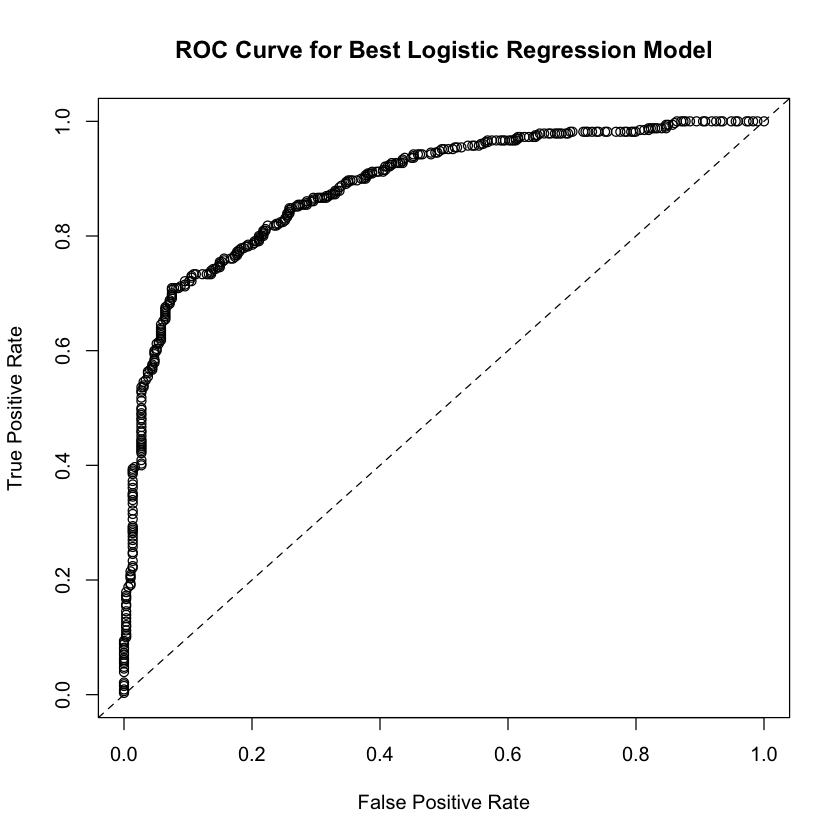

In [34]:
perf_glm_best <- h2o.performance(models_glm_best, valid)
plot(perf_glm_best, type="roc", main="ROC Curve for Best Logistic Regression Model")

We can also find which variables were the most important for this model!

In [35]:
#Variable importance
h2o.varimp(models_glm_best)

variable,relative_importance,scaled_importance,percentage
<chr>,<dbl>,<dbl>,<dbl>
EnvironmentSatisfaction,0.48148436,1.00000000,0.0438667774
YearsAtCompany,0.47577672,0.98814574,0.0433467694
YearsSinceLastPromotion,0.46781380,0.97160747,0.0426212884
BusinessTravel_Non-Travel,0.46313927,0.96189888,0.0421954042
OverTime_Yes,0.44001902,0.91388019,0.0400889790
OverTime_No,0.44001902,0.91388019,0.0400889790
YearsWithCurrManager,0.42475105,0.88216998,0.0386979543
JobRole_Laboratory Technician,0.41505353,0.86202911,0.0378144390
YearsInCurrentRole,0.40056220,0.83193191,0.0364941721
